# Horizontal conservative interpolation

In [1]:
import nes
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
countries = gpd.read_file('/gpfs/projects/bsc32/models/NES_tutorial_data/gadm_country_mask/gadm_country_ISO3166.shp')

def plot_data(nessy, var_name, zoom=None):
    nessy.create_spatial_bounds()
    lon_bnds, lat_bnds = nessy.get_spatial_bounds_mesh_format()
    
    fig, ax = plt.subplots(1, figsize=(19, 7))
    plt.pcolormesh(lon_bnds, 
                   lat_bnds, 
                   nessy.variables[var_name]['data'].sum(axis=(0, 1)), 
                   cmap='jet', 
                   norm=matplotlib.colors.LogNorm())
    
    countries.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.3)
    plt.colorbar(ax=ax)
    ax.margins(0)
    
    if zoom is not None:
        plt.axis([zoom['x_min'], zoom['x_max'], zoom['y_min'], zoom['y_max']])

    return None

## 1. Read data to interpolate

In [3]:
# Global CAMS domain
source_path = "/gpfs/projects/bsc32/models/NES_tutorial_data/nox_no_201505.nc"
var_name = "nox_no"

In [4]:
source_grid = nes.open_netcdf(path=source_path)
source_grid.keep_vars(var_name)
source_grid.load()

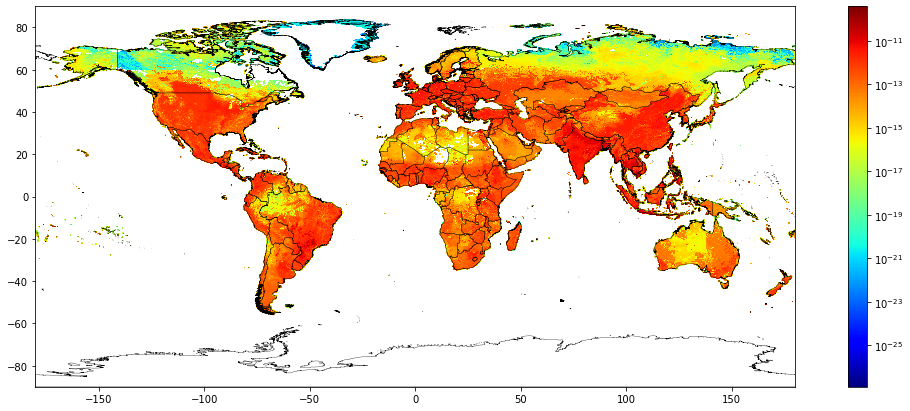

In [5]:
plot_data(source_grid, var_name)

## 2. Create destination grid

In [6]:
# CALIOPE EU domain (Lambert Conformal Conic 12x12 Km)

lat_1 = 37.
lat_2 = 43.
lon_0 = -3.
lat_0 = 40.
nx = 478
ny = 398
inc_x = 12000
inc_y = 12000
x_0 = -2131849.000
y_0 = -2073137.875

dst_nes = nes.create_nes(comm=None, info=False, projection='lcc', 
                     lat_1=lat_1, lat_2=lat_2, lon_0=lon_0, lat_0=lat_0,
                     nx=nx, ny=ny, inc_x=inc_x, inc_y=inc_y, x_0=x_0, y_0=y_0)

## 3. Interpolation

### 3.1. Create both shapefiles

If the shapefiles are not created previous the conservative interpolation they will be created inside the interpolation funcion.

Once created is not needed to create them anymore.

In [7]:
%time source_grid.create_shapefile()

CPU times: user 2min 35s, sys: 4.19 s, total: 2min 39s
Wall time: 2min 39s


geometry
FID                                                       
0        POLYGON ((-180.00000 -90.00000, -179.89999 -90...
1        POLYGON ((-179.90001 -90.00000, -179.80000 -90...
2        POLYGON ((-179.80000 -90.00000, -179.70000 -90...
3        POLYGON ((-179.70000 -90.00000, -179.59999 -90...
4        POLYGON ((-179.60001 -90.00000, -179.50000 -90...
...                                                    ...
6479995  POLYGON ((179.50000 89.89999, 179.60001 89.899...
6479996  POLYGON ((179.59999 89.89999, 179.70000 89.899...
6479997  POLYGON ((179.70000 89.89999, 179.80000 89.899...
6479998  POLYGON ((179.80000 89.89999, 179.90001 89.899...
6479999  POLYGON ((179.89999 89.89999, 180.00000 89.899...

[6480000 rows x 1 columns]

In [8]:
%time dst_nes.create_shapefile()

CPU times: user 4.73 s, sys: 33.8 ms, total: 4.77 s
Wall time: 4.78 s


geometry
FID                                                      
0       POLYGON ((-22.40086 19.60176, -22.29505 19.623...
1       POLYGON ((-22.29505 19.62375, -22.18918 19.645...
2       POLYGON ((-22.18918 19.64562, -22.08325 19.667...
3       POLYGON ((-22.08325 19.66739, -21.97728 19.689...
4       POLYGON ((-21.97728 19.68903, -21.87124 19.710...
...                                                   ...
190239  POLYGON ((53.04242 53.74019, 53.18577 53.67835...
190240  POLYGON ((53.18577 53.67835, 53.32878 53.61636...
190241  POLYGON ((53.32878 53.61636, 53.47145 53.55421...
190242  POLYGON ((53.47145 53.55421, 53.61379 53.49191...
190243  POLYGON ((53.61379 53.49191, 53.75580 53.42946...

[190244 rows x 1 columns]

### 3. Interpolation

In [9]:
%time interp_nes = source_grid.interpolate_horizontal(dst_nes, kind='Conservative')

CPU times: user 5min 38s, sys: 3.55 s, total: 5min 42s
Wall time: 5min 43s


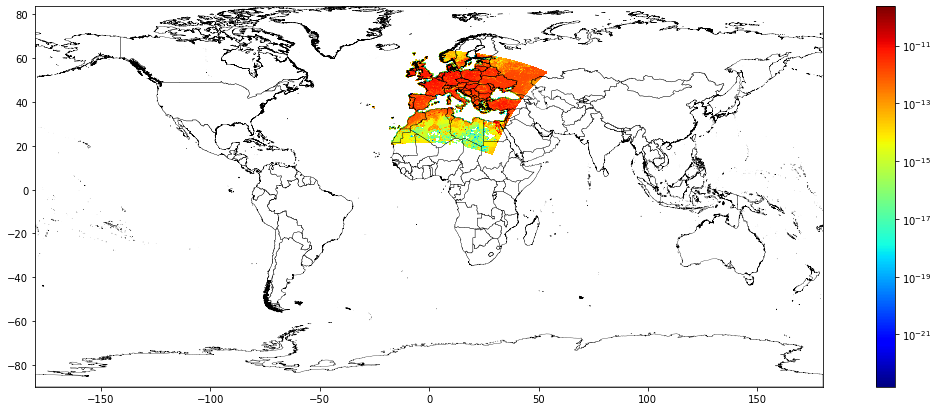

In [10]:
plot_data(interp_nes, var_name)

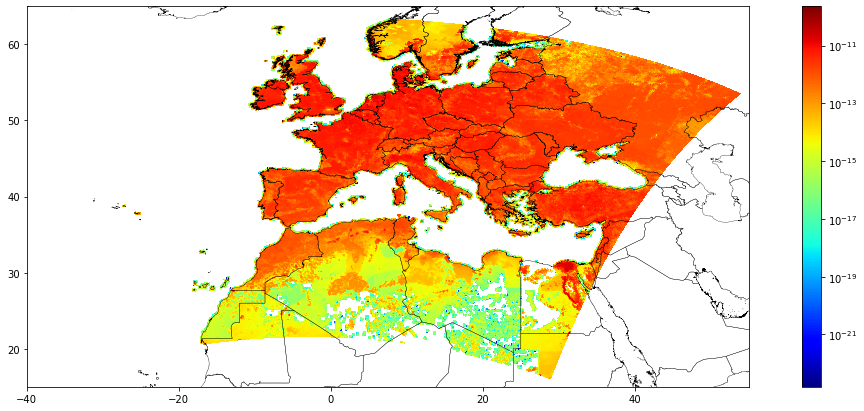

In [11]:
plot_data(interp_nes, var_name, zoom={'x_min': -40, 'x_max': 55, 'y_min': 15, 'y_max':65})

### 3.1 Flux conservative
Previous interpolation is wrong due to the fact that the data is in flux units and it has been applied the mass conservative method

In [12]:
source_grid.variables[var_name]['units']

'm-2.kg.s-1'

In [13]:
%time interp_nes = source_grid.interpolate_horizontal(dst_nes, kind='Conservative', flux=True)

CPU times: user 19min 56s, sys: 5.97 s, total: 20min 2s
Wall time: 20min 8s


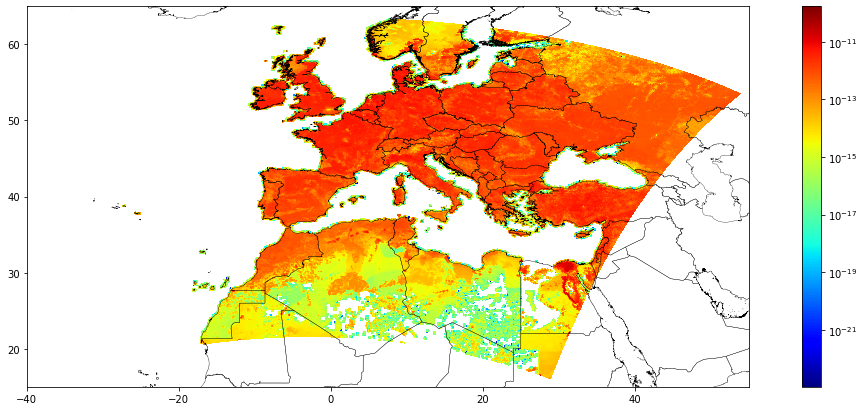

In [14]:
plot_data(interp_nes, var_name, zoom={'x_min': -40, 'x_max': 55, 'y_min': 15, 'y_max':65})

### 3.2. Creating weight matrix

The conservative interpolation takes lot of time to create the corresponding weight matrix.

It is possible to create it and then reuse it in twho different ways:

1. Save the WeightMatrix in memory
2. Save the WeightMatrix in a file

#### 3.2.1 Save Weight Matrix in memory

In [15]:
# Create WM

%time wm_nes = source_grid.interpolate_horizontal(dst_nes, kind='Conservative', only_create_wm=True, flux=True)

CPU times: user 20min 4s, sys: 6.93 s, total: 20min 11s
Wall time: 20min 17s


In [16]:
# Apply Interpolation

%time interp_nes = source_grid.interpolate_horizontal(dst_grid=dst_nes, kind='Conservative', wm=wm_nes)

CPU times: user 236 ms, sys: 16.9 ms, total: 253 ms
Wall time: 252 ms


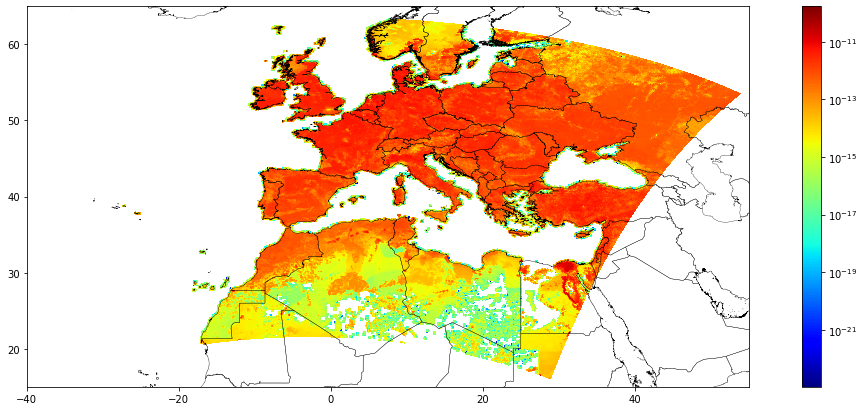

In [17]:
plot_data(interp_nes, var_name, zoom={'x_min': -40, 'x_max': 55, 'y_min': 15, 'y_max':65})

#### 3.2.2 Save Weight Matrix in a file

In [18]:
# Create WM file

%time source_grid.interpolate_horizontal(dst_nes, kind='Conservative', weight_matrix_path="WM.nc", only_create_wm=True, flux=True)

/gpfs/scratch/bsc32/bsc32538/NES_tests/NES/nes/nc_projections/default_nes.py:2453: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if var_dtype is np.object:


CPU times: user 20min 4s, sys: 6.55 s, total: 20min 11s
Wall time: 20min 17s


In [19]:
# Apply Interpolation

%time interp_nes = source_grid.interpolate_horizontal(dst_grid=dst_nes, kind='Conservative', weight_matrix_path="WM.nc")

/gpfs/scratch/bsc32/bsc32538/NES_tests/NES/nes/nc_projections/default_nes.py:1884: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if variables[var_name]['dtype'] in [str, np.object]:


CPU times: user 816 ms, sys: 33.8 ms, total: 850 ms
Wall time: 853 ms


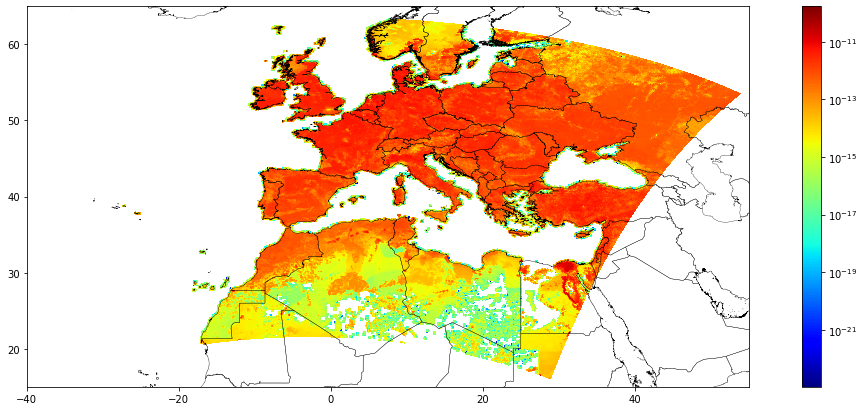

In [20]:
plot_data(interp_nes, var_name, zoom={'x_min': -40, 'x_max': 55, 'y_min': 15, 'y_max':65})